## Introduction

In this notebook, we explore several optimization methods commonly employed in deep learning tasks and assess their effectiveness using two test functions.


**Note:** You don't need GPU for this notebook. Save it for a rainy day!

In [11]:
# import dependencies
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display

display.clear_output()

## Test functions for optimization
In practical terms, when assessing the effectiveness of different optimization algorithms and hyperparameters, our primary concern lies in their performance across a diverse set of real-world challenges, particularly in optimizing a loss function. However, visualizing the actions of our algorithms may be challenging due to the complex, high-dimensional nature of loss landscapes, even with relatively simple neural networks trained on real-world datasets. To address this issue, various test functions have been proposed to provide insight into the scenarios that optimization algorithms may encounter.

In this notebook we use **Ackley function** and **Beale function**.

In [2]:
def ackley(x, y):
  return -20 * torch.exp(-0.2 * torch.sqrt(0.5 * (x**2 + y**2))) - torch.exp(0.5 * (torch.cos(2 * np.pi * x) + torch.cos(2 * np.pi * y))) + np.e + 20


def beale(x, y):
  return (1.5 - x + x * y)**2 + (2.25 - x + x * y**2)**2 + (2.625 - x + x * y**3)**2

In [16]:
# helper functions for ploting
def gen_2d_loss_surface(loss_func,
             n_x=100, # number of discretization points along the x-axis
             n_y=100, # number of discretization points along the x-axis
             min_x=-0.5, max_x=3.5, # extreme points in the x-axis
             min_y=-1.5, max_y=1.5 # extreme points in the y-axis
            ):

  # create a mesh of points at which to evaluate our function
  X, Y = torch.meshgrid(torch.linspace(min_x, max_x, n_x), torch.linspace(min_y, max_y, n_y), indexing='xy')

  # evaluate the func at all of the points
  Z = loss_func(X, Y).numpy()

  return X, Y, Z


def make_contour_plot(X, Y, Z, levels=None, cmap='viridis', log_scale=True, title="Contour Plot"):
    if levels is None:
        # generate 20 levels on a log scale
        levels = np.insert(np.logspace(0, 2.6, 40, True, base=10), 0, 0) if log_scale else np.linspace(Z.min(), Z.max(), 20)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    contour = ax.contour(X, Y, Z, levels=levels, cmap=cmap, alpha=0.5)
    ax.contourf(X, Y, Z, levels=levels, cmap=cmap, alpha=0.2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)
    fig.colorbar(contour, ax=ax)
    
    return fig, ax


def make_surface_plot(X, Y, Z, elevation=0, azimuth_angle=0, levels=None):
    if levels is None:
        # generate 20 levels on a log scale
        levels = np.insert(np.logspace(0, 2.6, 40, True, base=10), 0, 0)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elevation, azimuth_angle)
    
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.2)
    ax.contour(X, Y, Z, levels, cmap='viridis', alpha=0.5)
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label("Measurement")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    return fig, ax

### Ploting the test functions
Run the following cells provided for you to gain some intution about the landscape of ackley and beale functions.

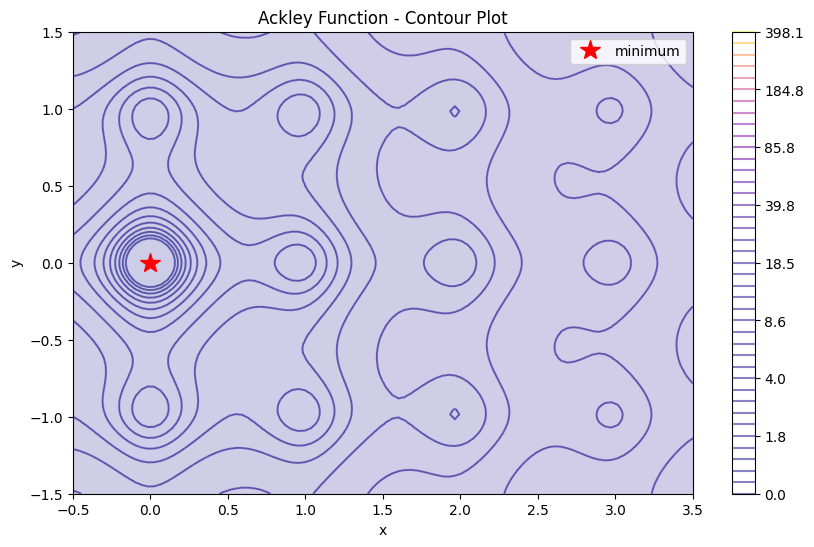

In [17]:
X, Y, Z = gen_2d_loss_surface(ackley)
fig, ax = make_contour_plot(X, Y, Z, cmap='plasma', title="Ackley Function - Contour Plot")
ax.plot(0, 0, 'r*', ms=15, label='minimum')
ax.legend()

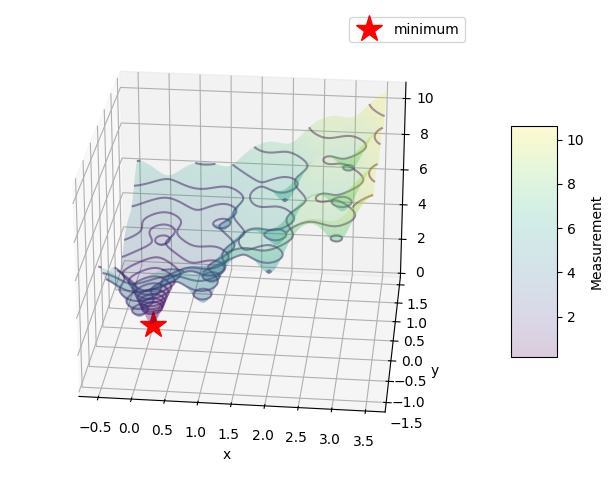

In [18]:
#run: "auto"
elevation = 25 #@param {type:"slider", min:0, max:360, step:1}
azimuth_angle = 276 #@param {type:"slider", min:0, max:360, step:1}

X, Y, Z = gen_2d_loss_surface(ackley)
fig, ax = make_surface_plot(X, Y, Z, elevation, azimuth_angle)

ax.plot([0], [0], 'r*', zs=[0], zdir='z', ms=20, label='minimum')
ax.legend()
plt.show()

As you can see, the ackley function is highly non-convex with multiple local minimas, which makes this a useful function for testing optimization algorithms.

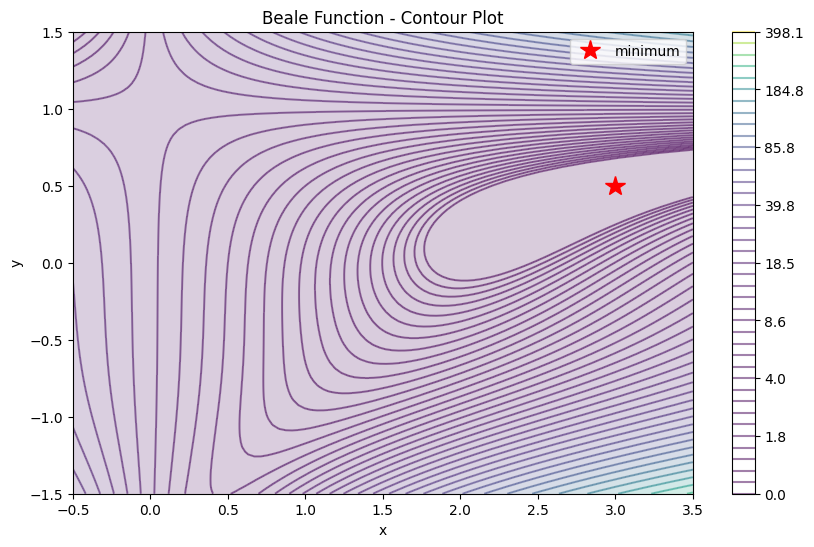

In [20]:
X, Y, Z = gen_2d_loss_surface(beale)
fig, ax = make_contour_plot(X, Y, Z, cmap='viridis', title="Beale Function - Contour Plot")
ax.plot(3, 0.5, 'r*', ms=15, label='minimum')
ax.legend()

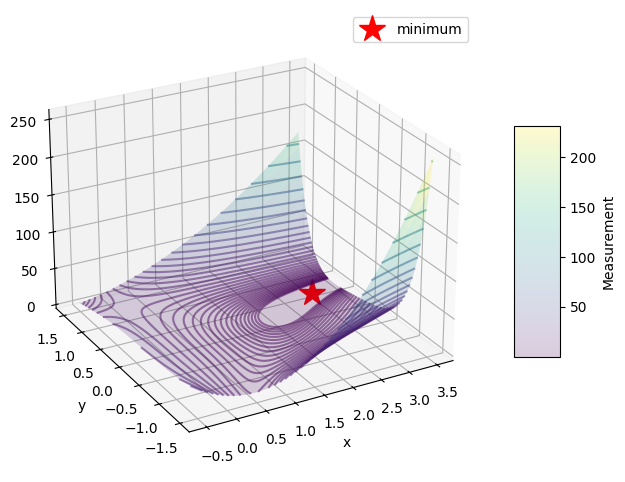

In [21]:
#run: "auto"
elevation = 25 #@param {type:"slider", min:0, max:360, step:1}
azimuth_angle = 241 #@param {type:"slider", min:0, max:360, step:1}

X, Y, Z = gen_2d_loss_surface(beale)
fig, ax = make_surface_plot(X, Y, Z, elevation, azimuth_angle)

ax.plot([3], [0.5], 'r*', zs=[0], zdir='z', ms=20, label='minimum')
ax.legend();

As you can see, within the valley, we have a global minimum. Finding the valley is relatively easy, but finding the global minimum is difficult, which makes this a useful function for testing optimization algorithms.